In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## guia 3 - ej 6


In [2]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/franciscokordon/estainferencia/main/data/blocks.csv"
)

In [3]:
data.head()

,Unnamed: 0,Child,Number,Time,Trial,Shape,Age
0,0,A,11,30.0,1,Cube,4.67
1,1,B,9,19.0,1,Cube,5.00
2,2,C,8,18.6,1,Cube,4.42
3,3,D,9,23.0,1,Cube,4.33
4,4,E,10,29.0,1,Cube,4.33


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  100 non-null    int64  
 1   Child       100 non-null    object 
 2   Number      100 non-null    int64  
 3   Time        100 non-null    float64
 4   Trial       100 non-null    int64  
 5   Shape       100 non-null    object 
 6   Age         100 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 5.6+ KB


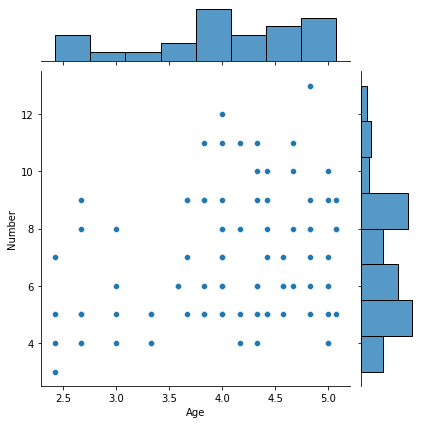

In [5]:
sns.jointplot(x="Age", y="Number", data=data)

Elijo una distribucion Poisson para Y. Con una funcion link eta = ln(mu) = g(mu)

In [6]:
def poisson_log_likelihood(y, mu):  # a menos de una constante
    return np.sum(y * np.log(mu) - mu)


def mle_poisson(beta, X, y):  # ln(mu) = nu = B0  + sum(Bi*Xi)
    mu = np.exp(np.dot(X, beta))
    return -poisson_log_likelihood(y, mu)

In [7]:
from scipy.optimize import minimize

Y = data["Number"]
X = np.column_stack((np.ones(len(data)), data["Age"]))

beta_init = np.zeros(2)

res = minimize(mle_poisson, beta_init, args=(X, Y), method="BFGS")

res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -630.9368538229929
        x: [ 1.345e+00  1.415e-01]
      nit: 9
      jac: [ 7.629e-06  7.629e-06]
 hess_inv: [[ 5.268e-02 -1.253e-02]
            [-1.253e-02  3.062e-03]]
     nfev: 39
     njev: 13

In [8]:
age_linspace = np.linspace(data["Age"].min(), data["Age"].max(), 10)
X_ = np.column_stack((np.ones(len(age_linspace)), age_linspace))
lower_bound, upper_bound = st.poisson.interval(0.95, np.exp(np.dot(X_, res.x)))

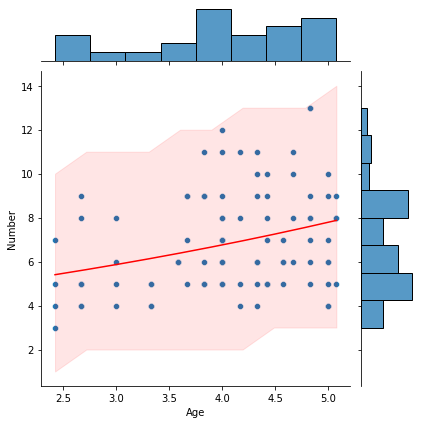

In [9]:
sns.jointplot(x="Age", y="Number", data=data)
plt.plot(age_linspace, np.exp(np.dot(X_, res.x)), color="red")
plt.fill_between(age_linspace, lower_bound, upper_bound, color="red", alpha=0.1)
plt.show()

In [10]:
W = np.diag(
    np.exp(np.dot(X, res.x))
)  # matriz de pesos, como use la variable canonica  (1/ dEta/dmu)
fischer_information = np.dot(
    X.T, np.dot(W, X)
)  # informacion de fisher (dispersion = 1 para poisson)
covariance_matrix = np.linalg.inv(fischer_information)  # matriz de covarianza
covariance_matrix

array([[ 0.04944115, -0.01169638],
       [-0.01169638,  0.0028516 ]])

In [11]:
standard_errors = np.sqrt(np.diag(covariance_matrix))
standard_errors

array([0.22235366, 0.0534004 ])

In [12]:
def poisson_unitary_deviance(y, mu):
    # representa diferencias entre el modelo y un modelo ideal saturado donde cada medicion es fitteada perfectamente (mu = y)
    return 2 * (y * np.log(y / mu) + (mu - y))


total_deviance = np.sum(poisson_unitary_deviance(Y, np.exp(np.dot(X, res.x))))
total_deviance

62.243835062448206

## guia 3 - ej 7


In [13]:
data2 = pd.read_csv(
    "https://raw.githubusercontent.com/franciscokordon/estainferencia/main/data/nambeware.csv"
)

In [14]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  59 non-null     int64  
 1   Type        59 non-null     object 
 2   Diam        59 non-null     float64
 3   Time        59 non-null     float64
 4   Price       59 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.4+ KB


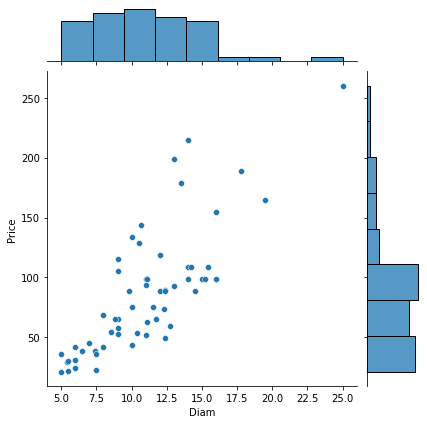

In [15]:
sns.jointplot(x="Diam", y="Price", data=data2)

obs: Aumento lineal del precio con el diametro. Tambien se observa aumento de la varianza con el aumento de la media de la variable dependiente. Propongo una distrib gamma debido a esto.

In [74]:
from scipy.special import gamma


def gamma_log_likelihood(y, mu, dispersion=1):
    A = (y / (dispersion * mu)) ** (1 / dispersion)
    B = (1 / y) * (1 / gamma(1 / dispersion))
    C = np.exp(-y / (dispersion * mu))
    return np.sum(np.log(A * B * C))


def mle_gamma(beta, X, y):  # uso de funcion link ln(mu) = eta
    mu = np.exp(np.dot(X, beta))
    return -gamma_log_likelihood(y, mu)

In [75]:
params_init = [2.9, 0.12]


Y2 = data2["Price"]
X2 = np.column_stack((np.ones(len(data2)), data2["Diam"]))


def to_minimize(beta):
    return mle_gamma(beta, X=X2, y=Y2)


result = minimize(to_minimize, x0=params_init, method="BFGS")
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 315.8304558995416
        x: [ 2.963e+00  1.272e-01]
      nit: 5
      jac: [ 0.000e+00 -3.815e-06]
 hess_inv: [[ 1.939e-01 -1.617e-02]
            [-1.617e-02  1.478e-03]]
     nfev: 27
     njev: 9

In [76]:
diam_linspace = np.linspace(data2["Diam"].min(), data2["Diam"].max(), 10)
X2_ = np.column_stack((np.ones(len(diam_linspace)), diam_linspace))

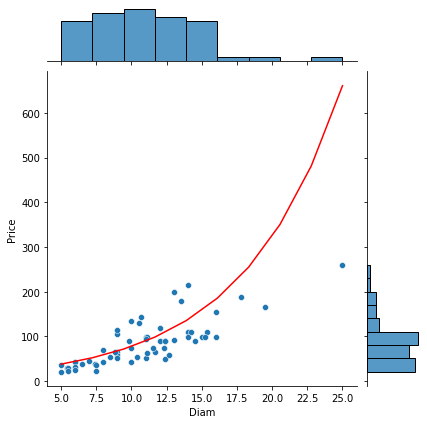

In [ ]:
sns.jointplot(x="Diam", y="Price", data=data2)
plt.plot(diam_linspace, np.exp(np.dot(X2_, result.x[0:-1])), color="red")

In [85]:
W = np.diag(np.exp(np.dot(X2, result.x)))

fischer_information = np.dot(X2.T, np.dot(W, X2))
covariance_matrix = np.linalg.inv(fischer_information)
standard_errors = np.sqrt(np.diag(covariance_matrix))
standard_errors

array([0.03976187, 0.0028014 ])

In [87]:
import statsmodels.api as sm

model = sm.GLM(Y2, X2, family=sm.families.Gamma(sm.families.links.Log())).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Price   No. Observations:                   59
Model:                            GLM   Df Residuals:                       57
Model Family:                   Gamma   Df Model:                            1
Link Function:                    Log   Scale:                         0.15673
Method:                          IRLS   Log-Likelihood:                -278.11
Date:                Wed, 24 Apr 2024   Deviance:                       7.7937
Time:                        16:43:23   Pearson chi2:                     8.93
No. Iterations:                    14   Pseudo R-squ. (CS):             0.7405
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9629      0.156     18.971      0.000       2.657       3.269
x1             0.1272      0.013      9.429      0.000       0.101       0.154
==============================================================================
"""

In [78]:
model.cov_params()

,const,x1
const,0.024392,-0.001989
x1,-0.001989,0.000182
